## Bachelor Thesis - Informatik

### Variante 4 :
### Multiclass-Klassifizierung mit Long Short Term Memory Network
***


<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage den folgenden Datensatz :

[https://github.com/michidk/myo-dataset]

###### ☑️ Der Datensatz wurde neu aufbereitet, siehe dazu --> [Link](Preprocessing.ipynb)

###### ☑️ 10 Testpersonen, nachfolgend Subjekte genannt, haben in 6 Sitzungen jeweils 10 Wiederholungen ausgeführt

###### ☑️ Alle Personen haben die folgenden drei Gesten in gleicher Position ausgeführt :

<img src="./Images/paper.png" width="150">         <img src="./Images/rock.png" width="150">        <img src="./Images/scissors.png" width="150">      

#### ▶️ Installation notwendiger Python-Bibliotheken
***

In [55]:
##############################################################
#      Dieses Notebook wurde mit Python 3.9.13 getestet      #
#                                                            #
#           Andere Versionen haben teilweise                 #
#           Kompatbilitätsprobleme verursacht                #
#                                                            #
#      This Notebook was tested with Python 3.9.13           #
#                                                            #
#              Other Versions can cause                      #
#                Compatibilityproblems                       #
#                                                            #
##############################################################

In [56]:
##############################################################
# Achtung!! Die Konvertierung des Modells nach C++           #
#           funktioniert nur mit Tensorflow <=2.15.1         #
#           Keras 3 funktioniert nicht!                      #
#                                                            #
# Attention! Converting the model to C++ ist only working    #
#            with Tensorflow <=2.15.1                        #
#            Keras 3 will not work!                          #
##############################################################

# %pip install -r requirements.txt
# %pip install -q "eloquent-tensorflow==1.0.5" "keras<3" embedded_window

#### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [57]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore

from embedded_window import Window # type: ignore

import logging
tf.get_logger().setLevel(logging.ERROR)


#### Hyperparameter für bestes Ergebnis:
***

- Window_size  = 16
- Window_shift = 2
- Batch_size   = 32
- Epochs       = 8
- LSTM Units   = 250
- Dense Units  = 32

Erreichte Validierungsgenauigkeit = 89,63 %

In [58]:
window_size = 16
window_shift = 2
window = Window(length=window_size, shift=window_shift)


def read_file(filename, plot: bool = False):
  df = pd.read_csv(filename)
  
  emg = df.iloc[:, 0:8]
    
  if plot:
    emg.plot(title=filename, legend=False)

  # normalize data
  # in this case, accel is in the range -3, 3
  # you have to adapt this line to your own data!
  emg_norm = emg.to_numpy()
  #emg_norm = np.clip(emg.to_numpy(), -10, 10)
  
  y = np.zeros(len(emg_norm))
  
  # apply window
  # returns a (N, window_length, accel.columns) array
  accel_windows, _, _ = window.fit_transform(emg_norm, y)
  return accel_windows


def get_Xy():
  """
  Read files
  One-hot encode y
  """
  x_paper = read_file('./Datasets/Concatenated/10SubjectsPaper.csv')
  x_rock = read_file('./Datasets/Concatenated/10SubjectsRock.csv')
  x_scissors = read_file('./Datasets/Concatenated/10SubjectsScissors.csv')
  

  y_paper = [0] * len(x_paper)
  y_rock = [1] * len(x_rock)
  y_scissors = [2] * len(x_scissors)


  X = np.vstack((x_paper, x_rock, x_scissors))
  y = np.concatenate((y_paper, y_rock, y_scissors))
  
  num_classes = y.max()
  
  eye = np.eye(num_classes + 1)
  y_hot = np.asarray([eye[yi] for yi in y], dtype=int)

  return X, y_hot


X, y = get_Xy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15)

X_test_file = X_test.reshape(-1,128)
X_val_file = X_val.reshape(-1,128)

# np.savetxt('../data/X_test.csv', X_test_file, delimiter=",", fmt='%f')
# np.savetxt('../data/y_test.csv', y_test, delimiter=",", fmt='%d')

np.savetxt('../data/X_val.csv', X_val_file, delimiter=",", fmt='%f')
np.savetxt('../data/y_val.csv', y_val, delimiter=",", fmt='%d')


num_classes = y.shape[1]

print("X.shape", X.shape)
print("Y.shape", y.shape)

print(X[0].size)

X.shape (260975, 16, 8)
Y.shape (260975, 3)
128


In [59]:
"""
Print samples of each class
"""
def print_sample(variable_name: str, filename: str):
  sample = read_file(filename, plot=False)[0].flatten()  
  values = ', '.join('%.4f' % x for x in sample)
  print(f'float {variable_name}[{len(sample)}] = {{ {values} }};')

 
print_sample('Papier', './Datasets/Concatenated/10SubjectsPaper.csv')
print_sample('Stein', './Datasets/Concatenated/10SubjectsRock.csv')
print_sample('Schere', './Datasets/Concatenated/10SubjectsScissors.csv')

float Papier[128] = { -7.0000, 1.0000, -21.0000, -7.0000, -3.0000, -12.0000, -4.0000, -9.0000, -6.0000, -13.0000, -20.0000, -5.0000, -1.0000, -2.0000, -26.0000, -16.0000, 35.0000, -2.0000, -2.0000, 2.0000, 3.0000, 8.0000, -4.0000, 9.0000, 0.0000, -3.0000, -7.0000, -2.0000, -1.0000, -3.0000, -3.0000, -10.0000, -7.0000, -15.0000, -33.0000, -12.0000, -6.0000, 9.0000, 36.0000, 4.0000, 6.0000, 21.0000, 37.0000, 10.0000, 2.0000, -10.0000, -51.0000, -5.0000, -25.0000, -53.0000, -53.0000, -30.0000, -14.0000, -4.0000, -15.0000, -16.0000, 1.0000, 15.0000, 43.0000, 4.0000, -1.0000, -11.0000, 4.0000, 1.0000, -7.0000, -13.0000, -21.0000, -13.0000, -5.0000, -10.0000, 8.0000, 0.0000, 26.0000, 3.0000, 40.0000, 9.0000, 6.0000, 8.0000, 20.0000, 2.0000, 7.0000, 25.0000, 68.0000, 30.0000, 9.0000, 22.0000, 24.0000, 29.0000, -22.0000, -29.0000, -85.0000, -29.0000, -12.0000, -32.0000, -41.0000, -24.0000, 1.0000, 0.0000, -16.0000, -6.0000, -6.0000, -11.0000, -10.0000, -7.0000, -4.0000, 6.0000, 6.0000, 2.0000,

In [60]:
##############################################################
# Hyperparameter                                             #
##############################################################
#batch_size = 16; epochs = 4; Dense 16 --> Lineare Kurve ohne Knicke, beides fallend --> Val Accurary : 0.7456
#batch_size = 16; epochs = 8; Dense 16 --> Validation Kurve steigt an --> Val Accurary --> 0.7388
#batch_size = 32; epochs = 4; Dense 16 --> Lineare Kurve ohne Knicke, beides fallend --> Val Accurary : 0.7378
#batch_size = 32; epochs = 4; Dense 32 --> Lineare Kurve ohne Knicke, beides fallend --> Val Accurary : 0.7414
#batch_size = 32; epochs = 8; Dense  8 --> Lineare Kurve ohne Knicke, beides fallend --> Val Accurary : 0.7318
#batch_size = 32; epochs = 8; Dense 128 --> Validation Kurve steigt an, beides fallend --> Val Accurary : 0.7318
#batch_size = 64; epochs = 4; Dense 16 --> Lineare Kurve ohne Knicke, beides fallend --> Val Accurary : 0.7319

batch_size = 256
epochs = 8

# Format der Eingabedaten festlegen
input_shape = X.shape[1:]
Klassen = y.shape[1]


model = keras.Sequential()
model.add(layers.InputLayer(input_shape))
model.add(layers.LSTM(60, unroll=False, return_sequences=True, activation='tanh'))
model.add(layers.LSTM(60, unroll=False, activation='tanh'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(Klassen, activation='softmax'))
  

# Modellparameter ausgeben
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16, 60)            16560     
                                                                 
 lstm_9 (LSTM)               (None, 60)                29040     
                                                                 
 dense_8 (Dense)             (None, 32)                1952      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 47651 (186.14 KB)
Trainable params: 47651 (186.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
   validation_data=(X_val, y_val),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
    ]
)

Epoch 1/8
737/737 [==============================] - 29s 34ms/step - loss: 0.7255 - accuracy: 0.6582 - val_loss: 0.6417 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 2/8
737/737 [==============================] - 26s 35ms/step - loss: 0.6079 - accuracy: 0.7220 - val_loss: 0.5933 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/8
737/737 [==============================] - 25s 35ms/step - loss: 0.5599 - accuracy: 0.7464 - val_loss: 0.5554 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 4/8
737/737 [==============================] - 25s 35ms/step - loss: 0.5227 - accuracy: 0.7637 - val_loss: 0.5311 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 5/8
737/737 [==============================] - 26s 35ms/step - loss: 0.4911 - accuracy: 0.7785 - val_loss: 0.5199 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 6/8
737/737 [==============================] - 25s 34ms/step - loss: 0.4655 - accuracy: 0.7919 - val_loss: 0.4934 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 7/8
737/737 [==============================] - 25s 35ms/st

#### ▶️ Exportiere das Modell nach C++
***

In [62]:
##############################################################
# Konvertiere Modell in Format für Headerfile                #
# Inhalt ab/inklusive der Zeile "#pragma once"               #
# in eine neue Datei mit Namen "Model.h" kopieren            #
##############################################################
from eloquent_tensorflow import convert_model # type: ignore
print(convert_model(model))


#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

// automatically configure network
#define TF_NUM_INPUTS 128
#define TF_NUM_OUTPUTS 3
#define TF_NUM_OPS 21

/**
 * Call this function to register the ops
 * that have been detected
 */
template<class TF>
void registerNetworkOps(TF& nn) {
    nn.resolver.AddFill();
    nn.resolver.AddTranspose();
    nn.resolver.AddGather();
    nn.resolver.AddLess();
    nn.resolver.AddWhile();
    nn.resolver.AddShape();
    nn.resolver.AddUnidirectionalSequenceLSTM();
    nn.resolver.AddFullyConnected();
    nn.resolver.AddConcatenation();
    nn.resolver.AddAdd();
    nn.resolver.AddSlice();
    nn.resolver.AddReshape();
    nn.resolver.AddSplit();
    nn.resolver.AddStridedSlice();
    nn.resolver.AddTanh

#### ▶️ Ausgabe der Verlustfunktion für Training und Validation
***

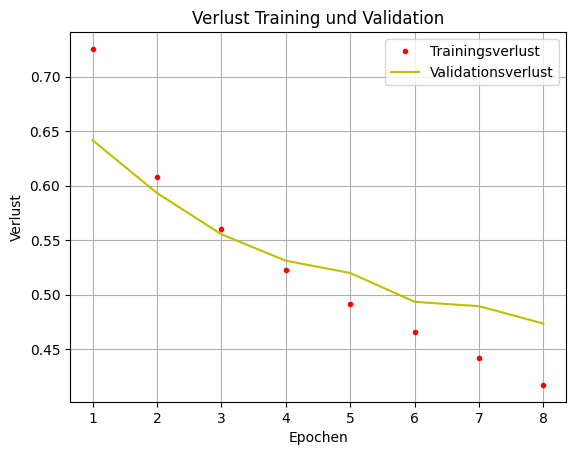

In [63]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'y', label='Validationsverlust')
plt.title('Verlust Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.grid()
plt.legend()
plt.savefig('./Images/Loss.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Ausgabe der Genauigkeit für Training und Validation
***

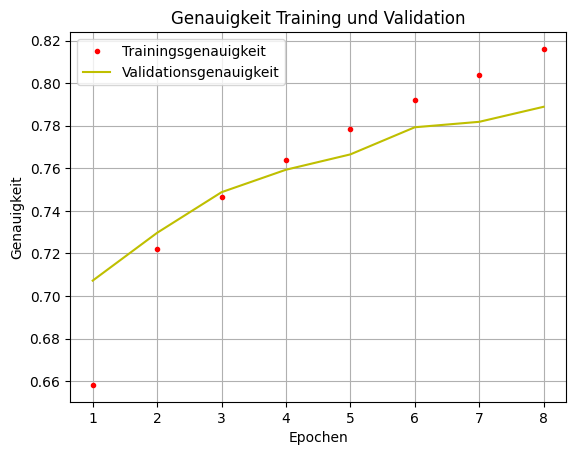

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'r.', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'y', label='Validationsgenauigkeit')
plt.title('Genauigkeit Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.grid()
plt.legend()
plt.savefig('./Images/Accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Modell auf Testdaten anwenden und evaluieren
***

In [65]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4734289348125458
Test accuracy: 0.7888805270195007


#### ▶️ Metriken zur Beurteilung der Modellqualität 
***

1224/1224 [==============================] - 7s 5ms/step


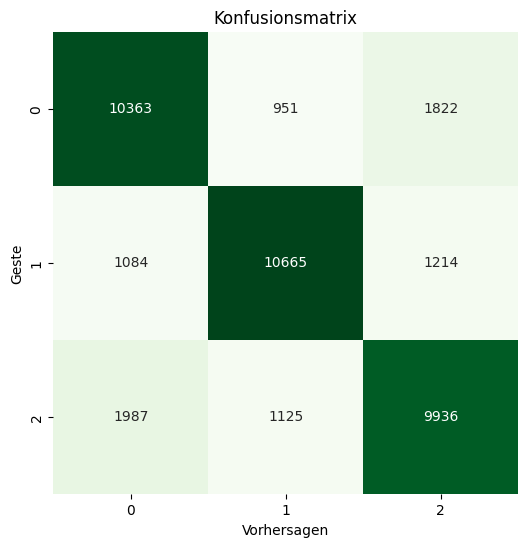

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     13136
           1       0.84      0.82      0.83     12963
           2       0.77      0.76      0.76     13048

    accuracy                           0.79     39147
   macro avg       0.79      0.79      0.79     39147
weighted avg       0.79      0.79      0.79     39147



In [66]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))